In [8]:
import sys
from pathlib import Path

IS_COLAB = "google.colab" in sys.modules
IS_KAGGLE = "kaggle_secrets" in sys.modules
if IS_KAGGLE:
    repo_path = Path("../input/microstructure-reconstruction")
elif IS_COLAB:
    from google.colab import drive

    drive.mount("/content/gdrive")
    repo_path = Path("/content/gdrive/MyDrive/microstructure-reconstruction")
else:
    repo_path = Path("/home/matias/microstructure-reconstruction")
sys.path.append(str(repo_path))

from copy import deepcopy
from importlib import reload

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pytorch_lightning as pl
import torch
import torch.nn as nn
import torch.optim as optim
import torchmetrics
import wandb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader
from torchvision import models as pretrained_models
from torchvision import transforms, utils
from tqdm import tqdm

from custom_datasets import dataset
from custom_models import models
from tools import dataframe_reformat, inspect_code, plotting, training, wandb_api

log_wandb = True

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
kwargs = {"num_workers": 2, "pin_memory": True} if use_cuda else {"num_workers": 4}
print(f"[INFO]: Computation device: {device}")


[INFO]: Computation device: cpu


## Export Fabrics Dataframe

In [9]:
run = wandb.init(
    project="microstructure-reconstruction",
    group="upload_artifact",
    job_type="upload_dataframe",
)

if log_wandb:
    config = wandb.config
else:
    config = {}

config["job_type"] = run.job_type if "run" in locals() else "test"
config["train_val_split"] = 0.7
config["seed"] = 42
config["log_wandb"] = log_wandb
torch.manual_seed(config["seed"])
pl.seed_everything(config["seed"])


Global seed set to 42


42

In [10]:
topLevelFolder = repo_path / "REV1_600"
path_to_revs = topLevelFolder / "REV1_6003D_model"
path_to_fabrics = topLevelFolder / "fabrics.txt"
path_to_slices = topLevelFolder / "REV1_600Slices"


In [4]:
nb_images = 10

fabrics_df = pd.read_csv(path_to_fabrics)
path_to_images = [x for x in path_to_slices.glob(f"{nb_images}p*/")]
fabrics_df["photos"] = fabrics_df["id"].apply(
    func=dataframe_reformat.associate_rev_id_to_its_images,
    args=(path_to_slices, nb_images, repo_path),
)
fabrics_df = fabrics_df[fabrics_df.photos.str.len().gt(0)]
fabrics_df["photos"] = fabrics_df["photos"].apply(func=lambda x: sorted(x))
train_df, test_df = train_test_split(
    fabrics_df,
    train_size=config["train_val_split"],
    random_state=config["seed"],
    shuffle=True,
)
train_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)
train_df.iloc[:, -1] = train_df.iloc[:, -1].apply(func=sorted, key=lambda path: float(path[path.find("[")+1:path.find("]")]))
test_df.iloc[:, -1] = test_df.iloc[:, -1].apply(func=sorted, key=lambda path: float(path[path.find("[")+1:path.find("]")]))

In [5]:
train_df

,id,nearest_distance_mean,nearest_distance_std,orientation-0_mean,orientation-1_mean,orientation-2_mean,orientation-3_mean,orientation-4_mean,orientation-5_mean,orientation-0_std,...,aspectratio-0_std,aspectratio-1_std,size_mean,size_std,solidity_mean,solidity_std,roundness_mean,roundness_std,volume_fraction,photos
0,Spec-26,6.853731,1.299158,0.342482,0.326164,0.331353,-0.002439,-0.009894,0.001967,0.305930,...,0.133029,0.092326,12.521809,3.236152,0.877774,0.048547,0.210038,0.076755,0.282953,[REV1_600/REV1_600Slices/10pics/Spec-26_Imgs/x...
1,Spec-155,6.284725,1.267244,0.330517,0.345945,0.323538,-0.011792,-0.006139,0.002618,0.310233,...,0.145667,0.100878,10.762842,2.938324,0.875227,0.057104,0.210821,0.087312,0.220033,[REV1_600/REV1_600Slices/10pics/Spec-155_Imgs/...
2,Spec-547,6.781135,1.111425,0.350816,0.379940,0.269244,0.245968,0.006432,0.001049,0.276976,...,0.137795,0.116401,11.320011,2.490452,0.915102,0.099076,0.277697,0.125270,0.293391,[REV1_600/REV1_600Slices/10pics/Spec-547_Imgs/...
3,Spec-181,6.245009,1.195427,0.332645,0.330792,0.336563,0.010419,0.001859,-0.001664,0.311602,...,0.145593,0.106760,12.634513,3.955245,0.852533,0.097699,0.211485,0.088914,0.375969,[REV1_600/REV1_600Slices/10pics/Spec-181_Imgs/...
4,Spec-451,6.620552,1.170357,0.147417,0.140031,0.712552,0.239643,-0.000092,-0.004413,0.154072,...,0.140649,0.117722,11.286373,2.605681,0.916626,0.091319,0.276328,0.129157,0.288797,[REV1_600/REV1_600Slices/10pics/Spec-451_Imgs/...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
433,Spec-14,6.233494,1.168641,0.335961,0.333907,0.330132,0.005292,0.009210,0.000688,0.307163,...,0.138637,0.103457,12.433393,3.714628,0.858285,0.091709,0.211356,0.087960,0.377875,[REV1_600/REV1_600Slices/10pics/Spec-14_Imgs/x...
434,Spec-171,6.534259,1.331457,0.323802,0.356842,0.319356,0.002839,0.002751,0.008704,0.303849,...,0.146998,0.108696,12.956666,3.940327,0.850465,0.099430,0.204419,0.086712,0.338117,[REV1_600/REV1_600Slices/10pics/Spec-171_Imgs/...
435,Spec-319,7.945857,1.464370,0.325574,0.328545,0.345882,-0.006096,0.007980,0.005561,0.305539,...,0.140020,0.128327,11.618068,2.801947,0.953685,0.080276,0.363426,0.148162,0.196165,[REV1_600/REV1_600Slices/10pics/Spec-319_Imgs/...
436,Spec-468,7.403535,1.510625,0.152658,0.148292,0.699051,0.242178,-0.010702,-0.006469,0.165516,...,0.135793,0.116337,11.790087,2.838719,0.910668,0.094105,0.268199,0.126921,0.180105,[REV1_600/REV1_600Slices/10pics/Spec-468_Imgs/...


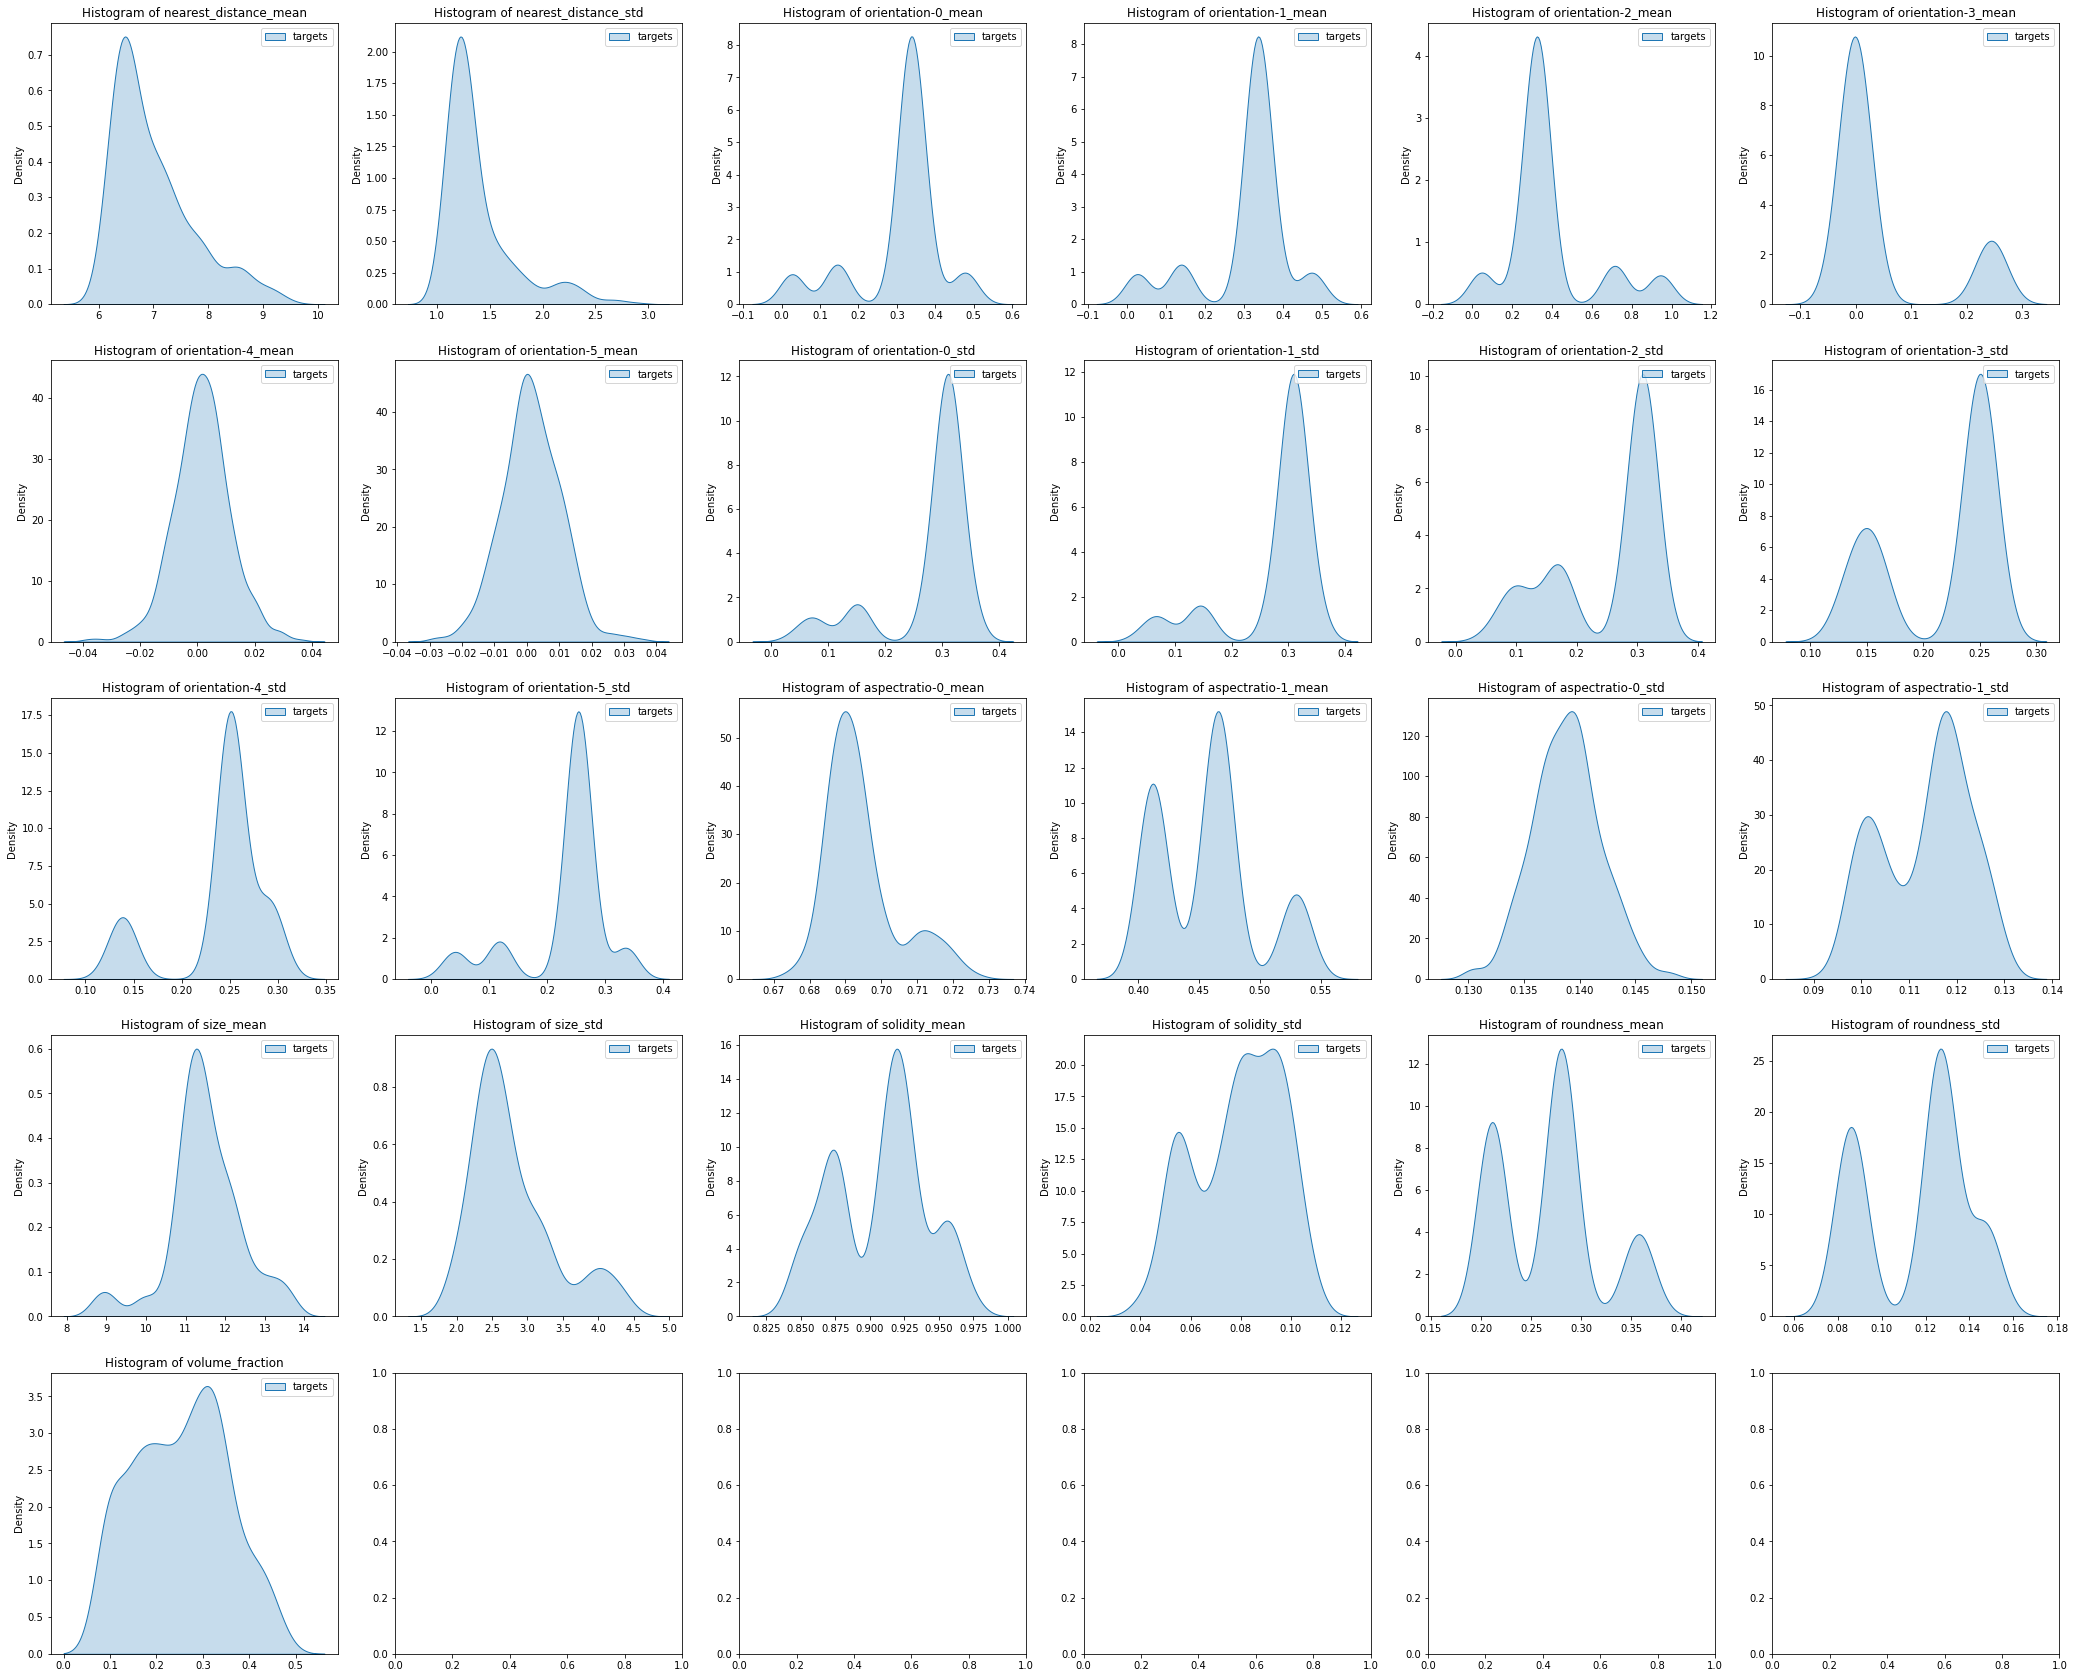

In [6]:
fig = plotting.plot_kde(train_df.iloc[:, 1:-1], nb_hist_per_line=6)

In [7]:
raw_data = wandb.Artifact(
    name="train_df",
    type="Fabrics",
)
table = wandb.Table(dataframe=train_df)
raw_data.add(table, name="fabrics")
run.log_artifact(raw_data, aliases=[f"{nb_images}_images"])

raw_data = wandb.Artifact(
    name="test_df",
    type="Fabrics",
)
table = wandb.Table(dataframe=test_df)
raw_data.add(table, name="fabrics")
run.log_artifact(raw_data, aliases=[f"{nb_images}_images"])
run.finish()


## Export Datasets

In [54]:
run = wandb.init(
    project="microstructure-reconstruction",
    group="upload_artifact",
    job_type="upload_dataset",
)
config = wandb.config
config.seed = 42
config.input_width = 64
config.train_val_split = 0.7
torch.manual_seed(config.seed)


In [55]:
data_at = run.use_artifact("raw_fabrics" + ":3_images")
data_dir = data_at.download()
fabrics_df = tools.convert_table_to_dataframe(data_at.get("fabrics"))
single_entry_df = tools.convert_into_single_entry_df(fabrics_df)

train_df, test_df = train_test_split(
    single_entry_df,
    train_size=config.train_val_split,
    random_state=config.seed,
    shuffle=True,
)
transform = transforms.Compose(
    [
        transforms.CenterCrop(207),
        transforms.Resize((config.input_width, config.input_width)),
        transforms.ToTensor(),
        transforms.GaussianBlur(kernel_size=3, sigma=0.5),
    ]
)

train_dataset = SinglePhotoDataset(train_df, normalization=True, transform=transform)
validation_dataset = SinglePhotoDataset(
    test_df, normalization=[train_dataset.max, train_dataset.min], transform=transform
)


In [56]:
train_artifact = wandb.Artifact(name="train_dataset", type="Datasets")
tools.add_torch_object(train_artifact, train_dataset, "train_dataset")
tools.add_pickle_object(
    train_artifact,
    {
        "script": tools.get_cell_code(type(train_dataset)),
        "members": tools.get_members(train_dataset),
    },
    "creation_data_train_dataset",
)
run.log_artifact(train_artifact)

val_artifact = wandb.Artifact(name="validation_dataset", type="Datasets")
tools.add_torch_object(val_artifact, validation_dataset, "validation_dataset")
tools.add_pickle_object(
    val_artifact,
    {
        "script": tools.get_cell_code(type(validation_dataset)),
        "members": tools.get_members(validation_dataset),
    },
    "creation_data_validation_dataset",
)
run.log_artifact(val_artifact)
run.finish()
